In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

# Optuna for hyperparameter tuning
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

print(f"Libraries loaded successfully")

Libraries loaded successfully at 21:07:28


In [ ]:
# Load data
train_df = pd.read_csv('../data/training_data.csv')
test_df = pd.read_csv('../data/test_data.csv')

# Convert timestamp
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])

print(f"Training data: {train_df.shape}")
print(f"Test data: {test_df.shape}")

Training data: (208910, 21)
Test data: (52228, 20)


In [11]:
# Feature engineering function (from V1 working baseline)
def engineer_features(df, is_training=True):
    """
    Create advanced features for wind turbine power prediction.
    """
    df = df.copy()
    
    # ========== Temporal Features ==========
    df['hour'] = df['timestamp'].dt.hour
    df['month'] = df['timestamp'].dt.month
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['dayofyear'] = df['timestamp'].dt.dayofyear
    df['quarter'] = df['timestamp'].dt.quarter
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    
    # Cyclic encoding for time features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
    df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)
    
    # ========== Wind Speed Features ==========
    df['wind_speed_squared'] = df['wind_speed_avg'] ** 2
    df['wind_speed_cubed'] = df['wind_speed_avg'] ** 3
    df['wind_speed_sqrt'] = np.sqrt(df['wind_speed_avg'])
    
    df['wind_speed_diff'] = np.abs(df['wind_speed1'] - df['wind_speed2'])
    df['wind_speed_ratio'] = df['wind_speed1'] / (df['wind_speed2'] + 0.001)
    df['wind_speed_max'] = df[['wind_speed1', 'wind_speed2']].max(axis=1)
    df['wind_speed_min'] = df[['wind_speed1', 'wind_speed2']].min(axis=1)
    
    # ========== Air Density Proxy ==========
    df['temp_kelvin'] = df['outdoor_temp'] + 273.15
    df['air_density_proxy'] = df['pressure'] / df['temp_kelvin']
    df['wind_power_theoretical'] = df['air_density_proxy'] * df['wind_speed_cubed']
    
    # ========== Direction Features ==========
    df['wind_nacelle_diff'] = np.abs(df['wind_angle'] - df['nacelle_angle'])
    df['wind_nacelle_diff'] = df['wind_nacelle_diff'].apply(lambda x: min(x, 360 - x) if x > 180 else x)
    df['wind_vane_diff'] = np.abs(df['wind_angle'] - df['vane_angle'])
    df['wind_vane_diff'] = df['wind_vane_diff'].apply(lambda x: min(x, 360 - x) if x > 180 else x)
    df['nacelle_alignment'] = np.cos(np.radians(df['wind_nacelle_diff']))
    
    # ========== Temperature Features ==========
    df['temp_diff'] = df['outdoor_temp'] - df['nacelle_temp']
    df['weather_outdoor_temp_diff'] = df['weather_temp'] - df['outdoor_temp']
    
    # ========== Rotor Features ==========
    df['rotor_angular_velocity_squared'] = df['rotor_angular_velocity'] ** 2
    
    # ========== Pitch Angle Features ==========
    df['is_shutdown'] = (df['pitch_angle'] > 40).astype(int)
    df['pitch_angle_squared'] = df['pitch_angle'] ** 2
    
    # ========== Weather Features ==========
    df['weather_wind_diff'] = np.abs(df['weather_wind_speed'] - df['wind_speed_avg'])
    df['has_rain'] = (df['rain_1h'] > 0).astype(int)
    df['has_snow'] = (df['snow_1h'] > 0).astype(int)
    
    # ========== Interaction Features ==========
    df['wind_temp_interaction'] = df['wind_speed_avg'] * df['outdoor_temp']
    df['wind_pressure_interaction'] = df['wind_speed_avg'] * df['pressure']
    df['wind_humidity_interaction'] = df['wind_speed_avg'] * df['humidity']
    df['rotor_wind_interaction'] = df['rotor_angular_velocity'] * df['wind_speed_avg']
    
    # ========== Rolling Features (only for training) ==========
    if is_training:
        window_sizes = [6, 12, 24]
        for window in window_sizes:
            df[f'wind_speed_rolling_mean_{window}'] = df['wind_speed_avg'].rolling(window=window, min_periods=1).mean()
            df[f'wind_speed_rolling_std_{window}'] = df['wind_speed_avg'].rolling(window=window, min_periods=1).std()
            df[f'power_rolling_mean_{window}'] = df['active_power'].rolling(window=window, min_periods=1).mean() if 'active_power' in df.columns else 0
    
    return df

print("Feature engineering function loaded")

Feature engineering function loaded


In [12]:
# Apply feature engineering
print("Engineering features...")
train_engineered = engineer_features(train_df, is_training=True)
test_engineered = engineer_features(test_df, is_training=False)

print(f"Engineered training features: {train_engineered.shape[1]}")
print(f"Engineered test features: {test_engineered.shape[1]}")

Engineering features...
Engineered training features: 67
Engineered test features: 57


In [13]:
# Prepare features
exclude_cols = ['timestamp', 'active_power']
train_features = [col for col in train_engineered.columns if col not in exclude_cols]
test_features = [col for col in test_engineered.columns if col != 'timestamp']
common_features = sorted(list(set(train_features) & set(test_features)))

X = train_engineered[common_features]
y = train_engineered['active_power']
X_test = test_engineered[common_features]

# Clean data
X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median())
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(X.median())

print(f"Features: {len(common_features)}")
print(f"Training samples: {len(X)}")
print(f"Test samples: {len(X_test)}")

Features: 56
Training samples: 208910
Test samples: 52228


In [14]:
# Split data (chronological)
split_idx = int(len(X) * 0.8)
X_train, X_val = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_val = y.iloc[:split_idx], y.iloc[split_idx:]

# Scale features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Training: {X_train_scaled.shape}")
print(f"Validation: {X_val_scaled.shape}")
print(f"Test: {X_test_scaled.shape}")

Training: (167128, 56)
Validation: (41782, 56)
Test: (52228, 56)


## 1. Hyperparameter Optimization with Optuna

This section implements Bayesian optimization using Optuna to fine-tune the hyperparameters of the XGBoost model. Optuna offers several advantages over traditional grid or random search methods:
- **Efficient Search**: Utilizes Bayesian optimization to explore the hyperparameter space more effectively.
- **Pruning**: Automatically terminates unpromising trials to save computational resources.
- **Flexibility**: Allows for complex objective functions and constraints.

In [15]:
# Define Optuna objective function
def objective(trial):
    """
    Objective function for Optuna to minimize (MAE)
    Conservative search space around V1 defaults
    """
    # Suggest hyperparameters (conservative ranges)
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 80, 300),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'gamma': trial.suggest_float('gamma', 0, 0.3),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 0.5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 2.0),
        'random_state': 42,
        'n_jobs': -1,
        'objective': 'reg:squarederror',
        'early_stopping_rounds': 20
    }
    
    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=3)
    mae_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_scaled)):
        X_tr, X_vl = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_tr, y_vl = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Train with early stopping
        model = xgb.XGBRegressor(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_vl, y_vl)],
            verbose=False
        )
        
        # Predict and score
        pred = model.predict(X_vl)
        mae = mean_absolute_error(y_vl, pred)
        mae_scores.append(mae)
        
        # Report intermediate value for pruning
        trial.report(mae, fold)
        
        # Prune if not promising
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return np.mean(mae_scores)

print("Objective function defined")

Objective function defined


In [ ]:
# Create Optuna study and optimize
print("Starting Optuna optimization...")

# Create study (minimize MAE)
study = optuna.create_study(
    direction='minimize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1)
)

# Optimize
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n" + "="*60)
print("OPTIMIZATION COMPLETE")
print("="*60)
print(f"Best MAE: {study.best_value:.4f}")
print(f"\nBest parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-20 21:07:30,134] A new study created in memory with name: no-name-ec0a6fa8-7e78-495a-8d8a-b667d9fd70cf


Starting Optuna optimization...
This will take 10-20 minutes with 50 trials


Best trial: 0. Best value: 10.8237:   2%|▏         | 1/50 [00:05<04:37,  5.66s/it]

[I 2025-11-20 21:07:35,796] Trial 0 finished with value: 10.823695909885013 and parameters: {'n_estimators': 196, 'max_depth': 8, 'learning_rate': 0.055522359285499465, 'subsample': 0.9081807867081734, 'colsample_bytree': 0.9933959546554699, 'min_child_weight': 3, 'gamma': 0.13612331961485277, 'reg_alpha': 0.2118003842547494, 'reg_lambda': 0.5627994269753025}. Best is trial 0 with value: 10.823695909885013.


Best trial: 0. Best value: 10.8237:   4%|▍         | 2/50 [00:07<02:48,  3.51s/it]

[I 2025-11-20 21:07:37,803] Trial 1 finished with value: 11.203538537903427 and parameters: {'n_estimators': 298, 'max_depth': 7, 'learning_rate': 0.16127022064411917, 'subsample': 0.9269294390486356, 'colsample_bytree': 0.7423539176492296, 'min_child_weight': 6, 'gamma': 0.23308467516291098, 'reg_alpha': 0.06968956010283911, 'reg_lambda': 0.6812029861801783}. Best is trial 0 with value: 10.823695909885013.


Best trial: 0. Best value: 10.8237:   6%|▌         | 3/50 [00:11<03:01,  3.86s/it]

[I 2025-11-20 21:07:42,073] Trial 2 finished with value: 11.151294844428769 and parameters: {'n_estimators': 215, 'max_depth': 10, 'learning_rate': 0.15770431913295696, 'subsample': 0.7605739542944191, 'colsample_bytree': 0.8626500955857778, 'min_child_weight': 3, 'gamma': 0.1672008567787211, 'reg_alpha': 0.28624287098951523, 'reg_lambda': 0.9689525000347896}. Best is trial 0 with value: 10.823695909885013.


Best trial: 0. Best value: 10.8237:   8%|▊         | 4/50 [00:15<02:49,  3.69s/it]

[I 2025-11-20 21:07:45,514] Trial 3 finished with value: 11.033107344105218 and parameters: {'n_estimators': 288, 'max_depth': 6, 'learning_rate': 0.08375952425515758, 'subsample': 0.7662116979307957, 'colsample_bytree': 0.954472976718392, 'min_child_weight': 3, 'gamma': 0.20177025370517118, 'reg_alpha': 0.1040936729713246, 'reg_lambda': 1.078600513024012}. Best is trial 0 with value: 10.823695909885013.


Best trial: 0. Best value: 10.8237:  10%|█         | 5/50 [00:18<02:43,  3.64s/it]

[I 2025-11-20 21:07:49,065] Trial 4 finished with value: 11.172431563723693 and parameters: {'n_estimators': 240, 'max_depth': 7, 'learning_rate': 0.11997242109736506, 'subsample': 0.800977316308218, 'colsample_bytree': 0.8025994144224274, 'min_child_weight': 7, 'gamma': 0.14506608254580433, 'reg_alpha': 0.49108004092154806, 'reg_lambda': 0.538122135913116}. Best is trial 0 with value: 10.823695909885013.


Best trial: 0. Best value: 10.8237:  12%|█▏        | 6/50 [00:23<02:54,  3.97s/it]

[I 2025-11-20 21:07:53,676] Trial 5 finished with value: 10.922263803794854 and parameters: {'n_estimators': 239, 'max_depth': 9, 'learning_rate': 0.1204766324322533, 'subsample': 0.771244060360202, 'colsample_bytree': 0.9591001033176131, 'min_child_weight': 6, 'gamma': 0.024223720704782504, 'reg_alpha': 0.36879926670099306, 'reg_lambda': 1.0758885437267258}. Best is trial 0 with value: 10.823695909885013.


Best trial: 0. Best value: 10.8237:  14%|█▍        | 7/50 [00:27<02:49,  3.94s/it]

[I 2025-11-20 21:07:57,551] Trial 6 finished with value: 11.390957089067463 and parameters: {'n_estimators': 233, 'max_depth': 5, 'learning_rate': 0.05014959267267051, 'subsample': 0.8828726783205284, 'colsample_bytree': 0.7704333905960293, 'min_child_weight': 2, 'gamma': 0.02628708965696633, 'reg_alpha': 0.40100579552833615, 'reg_lambda': 1.2397658354377596}. Best is trial 0 with value: 10.823695909885013.


Best trial: 0. Best value: 10.8237:  16%|█▌        | 8/50 [00:29<02:26,  3.49s/it]

[I 2025-11-20 21:08:00,086] Trial 7 finished with value: 12.219407039110306 and parameters: {'n_estimators': 169, 'max_depth': 4, 'learning_rate': 0.12335028737752654, 'subsample': 0.7996517658811009, 'colsample_bytree': 0.7236129240107366, 'min_child_weight': 6, 'gamma': 0.2961747699204867, 'reg_alpha': 0.42387488709370175, 'reg_lambda': 1.5504360574242415}. Best is trial 0 with value: 10.823695909885013.


Best trial: 0. Best value: 10.8237:  18%|█▊        | 9/50 [00:34<02:31,  3.70s/it]

[I 2025-11-20 21:08:04,245] Trial 8 finished with value: 10.874818351100215 and parameters: {'n_estimators': 196, 'max_depth': 8, 'learning_rate': 0.08167985561878713, 'subsample': 0.9570175777092526, 'colsample_bytree': 0.8228681815777228, 'min_child_weight': 5, 'gamma': 0.06091915650791967, 'reg_alpha': 0.17341181691297713, 'reg_lambda': 1.4085138448903993}. Best is trial 0 with value: 10.823695909885013.


Best trial: 0. Best value: 10.8237:  20%|██        | 10/50 [00:35<02:05,  3.13s/it]

[I 2025-11-20 21:08:06,100] Trial 9 finished with value: 11.796425504248441 and parameters: {'n_estimators': 201, 'max_depth': 5, 'learning_rate': 0.1778727342667702, 'subsample': 0.9367265659743339, 'colsample_bytree': 0.735595887018023, 'min_child_weight': 2, 'gamma': 0.2772189803694655, 'reg_alpha': 0.0648818122368402, 'reg_lambda': 1.267324123489178}. Best is trial 0 with value: 10.823695909885013.


Best trial: 0. Best value: 10.8237:  22%|██▏       | 11/50 [00:40<02:21,  3.62s/it]

[I 2025-11-20 21:08:10,814] Trial 10 finished with value: 11.560273537741034 and parameters: {'n_estimators': 102, 'max_depth': 10, 'learning_rate': 0.26578678921818694, 'subsample': 0.9929218281146526, 'colsample_bytree': 0.8965099476719125, 'min_child_weight': 1, 'gamma': 0.110605967072652, 'reg_alpha': 0.23876952671180857, 'reg_lambda': 1.8323134576218196}. Best is trial 0 with value: 10.823695909885013.


Best trial: 0. Best value: 10.8237:  24%|██▍       | 12/50 [00:45<02:26,  3.85s/it]

[I 2025-11-20 21:08:15,198] Trial 11 finished with value: 10.993741481756851 and parameters: {'n_estimators': 156, 'max_depth': 8, 'learning_rate': 0.057594368838811784, 'subsample': 0.9984447818690109, 'colsample_bytree': 0.8253432223721723, 'min_child_weight': 4, 'gamma': 0.08492929650819174, 'reg_alpha': 0.19869721167069002, 'reg_lambda': 1.5740486045196571}. Best is trial 0 with value: 10.823695909885013.


Best trial: 12. Best value: 10.7274:  26%|██▌       | 13/50 [00:48<02:22,  3.86s/it]

[I 2025-11-20 21:08:19,075] Trial 12 finished with value: 10.727378642402362 and parameters: {'n_estimators': 141, 'max_depth': 8, 'learning_rate': 0.07367739005447835, 'subsample': 0.8711130704292629, 'colsample_bytree': 0.9953811334303747, 'min_child_weight': 4, 'gamma': 0.07193885478158372, 'reg_alpha': 0.16081590805100685, 'reg_lambda': 0.813305245160451}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  28%|██▊       | 14/50 [00:52<02:18,  3.83s/it]

[I 2025-11-20 21:08:22,853] Trial 13 finished with value: 10.964328220109252 and parameters: {'n_estimators': 115, 'max_depth': 8, 'learning_rate': 0.06988813196647345, 'subsample': 0.8791274174796735, 'colsample_bytree': 0.9987381226767221, 'min_child_weight': 4, 'gamma': 0.12412054671349917, 'reg_alpha': 0.005324465613014112, 'reg_lambda': 0.7816194201216791}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  30%|███       | 15/50 [00:58<02:31,  4.34s/it]

[I 2025-11-20 21:08:28,367] Trial 14 finished with value: 10.81751876424193 and parameters: {'n_estimators': 141, 'max_depth': 9, 'learning_rate': 0.0656852019454349, 'subsample': 0.8454429488681786, 'colsample_bytree': 0.917922527611846, 'min_child_weight': 3, 'gamma': 0.06866798646235217, 'reg_alpha': 0.2809901810897465, 'reg_lambda': 0.5097186679730188}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  32%|███▏      | 16/50 [01:02<02:29,  4.40s/it]

[I 2025-11-20 21:08:32,903] Trial 15 finished with value: 10.857615549018044 and parameters: {'n_estimators': 133, 'max_depth': 9, 'learning_rate': 0.08219417008499218, 'subsample': 0.8448495846881834, 'colsample_bytree': 0.9002875092684072, 'min_child_weight': 5, 'gamma': 0.06652228046878952, 'reg_alpha': 0.3081598742579728, 'reg_lambda': 0.8737791857039636}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  34%|███▍      | 17/50 [01:07<02:24,  4.37s/it]

[I 2025-11-20 21:08:37,219] Trial 16 finished with value: 11.027418362565319 and parameters: {'n_estimators': 86, 'max_depth': 9, 'learning_rate': 0.06582888369468966, 'subsample': 0.7097380633101447, 'colsample_bytree': 0.9296363538703534, 'min_child_weight': 1, 'gamma': 0.008239398214801241, 'reg_alpha': 0.14419275814272717, 'reg_lambda': 0.7088003296720644}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  36%|███▌      | 18/50 [01:12<02:34,  4.83s/it]

[I 2025-11-20 21:08:43,111] Trial 17 finished with value: 10.903370197686955 and parameters: {'n_estimators': 147, 'max_depth': 10, 'learning_rate': 0.09612230551961352, 'subsample': 0.848073180204919, 'colsample_bytree': 0.8864643705726855, 'min_child_weight': 2, 'gamma': 0.09544436871997702, 'reg_alpha': 0.2793539875120768, 'reg_lambda': 0.549269684539696}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  38%|███▊      | 19/50 [01:15<02:04,  4.01s/it]

[I 2025-11-20 21:08:45,198] Trial 18 finished with value: 11.000980023647339 and parameters: {'n_estimators': 125, 'max_depth': 6, 'learning_rate': 0.10006435433345653, 'subsample': 0.8253693720107045, 'colsample_bytree': 0.9428332254621217, 'min_child_weight': 5, 'gamma': 0.057819611807051044, 'reg_alpha': 0.33509001892531093, 'reg_lambda': 1.9902508467092976}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  40%|████      | 20/50 [01:20<02:14,  4.49s/it]

[I 2025-11-20 21:08:50,817] Trial 19 finished with value: 10.863949114610817 and parameters: {'n_estimators': 170, 'max_depth': 9, 'learning_rate': 0.06716901079045061, 'subsample': 0.8778520627889721, 'colsample_bytree': 0.9742522429020872, 'min_child_weight': 4, 'gamma': 0.18464452424861905, 'reg_alpha': 0.14618044455263451, 'reg_lambda': 0.8532123632798606}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  42%|████▏     | 21/50 [01:22<01:43,  3.57s/it]

[I 2025-11-20 21:08:52,228] Trial 20 finished with value: 11.385592391715297 and parameters: {'n_estimators': 83, 'max_depth': 7, 'learning_rate': 0.25404279229576243, 'subsample': 0.7196916782013228, 'colsample_bytree': 0.9194104468217676, 'min_child_weight': 3, 'gamma': 0.03939693765134526, 'reg_alpha': 0.24166557929748544, 'reg_lambda': 0.6955617935885705}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  44%|████▍     | 22/50 [01:27<01:55,  4.11s/it]

[I 2025-11-20 21:08:57,620] Trial 21 finished with value: 10.747257920561358 and parameters: {'n_estimators': 170, 'max_depth': 8, 'learning_rate': 0.050217828049890154, 'subsample': 0.9116718996062565, 'colsample_bytree': 0.9945568579279982, 'min_child_weight': 3, 'gamma': 0.12511265844865332, 'reg_alpha': 0.21054104266107204, 'reg_lambda': 0.5975365722239592}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  46%|████▌     | 23/50 [01:32<02:00,  4.46s/it]

[I 2025-11-20 21:09:02,881] Trial 22 finished with value: 10.793092260808663 and parameters: {'n_estimators': 172, 'max_depth': 8, 'learning_rate': 0.059213016561217906, 'subsample': 0.8979252350623872, 'colsample_bytree': 0.9769389174443077, 'min_child_weight': 3, 'gamma': 0.09076396781521953, 'reg_alpha': 0.13315563100765357, 'reg_lambda': 0.5032500608450211}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  48%|████▊     | 24/50 [01:38<02:07,  4.90s/it]

[I 2025-11-20 21:09:08,820] Trial 23 finished with value: 10.808948269886145 and parameters: {'n_estimators': 173, 'max_depth': 8, 'learning_rate': 0.05302347771110003, 'subsample': 0.9004913053763827, 'colsample_bytree': 0.9760537684414846, 'min_child_weight': 2, 'gamma': 0.11123735854319809, 'reg_alpha': 0.0949412379486651, 'reg_lambda': 0.6746882187238163}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  50%|█████     | 25/50 [01:41<01:46,  4.27s/it]

[I 2025-11-20 21:09:11,607] Trial 24 finished with value: 11.030077993909217 and parameters: {'n_estimators': 177, 'max_depth': 6, 'learning_rate': 0.07434431449173302, 'subsample': 0.9605277903438605, 'colsample_bytree': 0.9719141442495931, 'min_child_weight': 4, 'gamma': 0.09197027986570805, 'reg_alpha': 0.13941434577333378, 'reg_lambda': 0.9285083863821599}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  52%|█████▏    | 26/50 [01:45<01:38,  4.10s/it]

[I 2025-11-20 21:09:15,320] Trial 25 finished with value: 11.034280939472657 and parameters: {'n_estimators': 158, 'max_depth': 7, 'learning_rate': 0.05919251125695425, 'subsample': 0.9130703142797, 'colsample_bytree': 0.9979444464639162, 'min_child_weight': 5, 'gamma': 0.17092016498333437, 'reg_alpha': 0.028177658828778457, 'reg_lambda': 0.7749509259225158}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  54%|█████▍    | 27/50 [01:49<01:35,  4.14s/it]

[I 2025-11-20 21:09:19,546] Trial 26 finished with value: 10.952503357839921 and parameters: {'n_estimators': 107, 'max_depth': 8, 'learning_rate': 0.06027396253044398, 'subsample': 0.9502735147346056, 'colsample_bytree': 0.9393684351104539, 'min_child_weight': 3, 'gamma': 0.12750167509210164, 'reg_alpha': 0.198221783776317, 'reg_lambda': 0.6270732967678583}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  56%|█████▌    | 28/50 [01:52<01:26,  3.95s/it]

[I 2025-11-20 21:09:23,053] Trial 27 finished with value: 10.928304121066171 and parameters: {'n_estimators': 213, 'max_depth': 7, 'learning_rate': 0.09659089169513906, 'subsample': 0.8662697384816526, 'colsample_bytree': 0.8674914449185134, 'min_child_weight': 4, 'gamma': 0.00033620738036785336, 'reg_alpha': 0.11639894503166195, 'reg_lambda': 1.1030488651186143}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  58%|█████▊    | 29/50 [01:57<01:28,  4.21s/it]

[I 2025-11-20 21:09:27,862] Trial 28 finished with value: 10.816235345033613 and parameters: {'n_estimators': 183, 'max_depth': 8, 'learning_rate': 0.07717690367784295, 'subsample': 0.8957883523132393, 'colsample_bytree': 0.9792645985936761, 'min_child_weight': 2, 'gamma': 0.15887214878870576, 'reg_alpha': 0.17405655215157229, 'reg_lambda': 0.8128173828468196}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  60%|██████    | 30/50 [02:03<01:32,  4.61s/it]

[I 2025-11-20 21:09:33,418] Trial 29 finished with value: 10.815947444033021 and parameters: {'n_estimators': 151, 'max_depth': 8, 'learning_rate': 0.051881467027984164, 'subsample': 0.9187958022093685, 'colsample_bytree': 0.9881460198324252, 'min_child_weight': 3, 'gamma': 0.21664057133377296, 'reg_alpha': 0.0542527854580008, 'reg_lambda': 0.6071057421536745}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  62%|██████▏   | 31/50 [02:13<01:57,  6.21s/it]

[I 2025-11-20 21:09:43,358] Trial 30 finished with value: 10.855321008430655 and parameters: {'n_estimators': 258, 'max_depth': 9, 'learning_rate': 0.06076870790290423, 'subsample': 0.977582017081505, 'colsample_bytree': 0.9570938690452447, 'min_child_weight': 1, 'gamma': 0.04619632741852481, 'reg_alpha': 0.2287024841585768, 'reg_lambda': 0.9886974795346033}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  64%|██████▍   | 32/50 [02:19<01:52,  6.26s/it]

[I 2025-11-20 21:09:49,748] Trial 31 finished with value: 10.805785311099376 and parameters: {'n_estimators': 186, 'max_depth': 8, 'learning_rate': 0.050500180368387326, 'subsample': 0.9001914173342278, 'colsample_bytree': 0.9743797680176414, 'min_child_weight': 2, 'gamma': 0.11359902436714647, 'reg_alpha': 0.09987858157343082, 'reg_lambda': 0.5049146383074935}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  66%|██████▌   | 33/50 [02:25<01:44,  6.12s/it]

[I 2025-11-20 21:09:55,544] Trial 32 finished with value: 10.771543584810644 and parameters: {'n_estimators': 190, 'max_depth': 8, 'learning_rate': 0.0559964288062682, 'subsample': 0.9347329789037453, 'colsample_bytree': 0.9995130447094157, 'min_child_weight': 2, 'gamma': 0.13862929953231395, 'reg_alpha': 0.17647118178289917, 'reg_lambda': 0.5095027111821016}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  68%|██████▊   | 34/50 [02:29<01:28,  5.55s/it]

[I 2025-11-20 21:09:59,743] Trial 33 finished with value: 10.891940931119203 and parameters: {'n_estimators': 208, 'max_depth': 7, 'learning_rate': 0.0569327687597012, 'subsample': 0.9339370534899354, 'colsample_bytree': 0.992600261147183, 'min_child_weight': 4, 'gamma': 0.14149210046720034, 'reg_alpha': 0.17582411014844448, 'reg_lambda': 0.6189413564433184}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  70%|███████   | 35/50 [02:32<01:12,  4.83s/it]

[I 2025-11-20 21:10:02,917] Trial 34 finished with value: 10.896021786557213 and parameters: {'n_estimators': 135, 'max_depth': 7, 'learning_rate': 0.06348231352448341, 'subsample': 0.8627668942848328, 'colsample_bytree': 0.9545754007433079, 'min_child_weight': 3, 'gamma': 0.08615788813941179, 'reg_alpha': 0.21106109581348315, 'reg_lambda': 0.7376392025361485}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  72%|███████▏  | 36/50 [02:38<01:11,  5.13s/it]

[I 2025-11-20 21:10:08,723] Trial 35 finished with value: 10.769678879996263 and parameters: {'n_estimators': 164, 'max_depth': 9, 'learning_rate': 0.07499161754327636, 'subsample': 0.9234063045222869, 'colsample_bytree': 0.9618241085412421, 'min_child_weight': 3, 'gamma': 0.18494829386074585, 'reg_alpha': 0.25745508838709713, 'reg_lambda': 0.6087528171149562}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  74%|███████▍  | 37/50 [02:43<01:06,  5.11s/it]

[I 2025-11-20 21:10:13,808] Trial 36 finished with value: 10.744428803814102 and parameters: {'n_estimators': 160, 'max_depth': 9, 'learning_rate': 0.08954665007249181, 'subsample': 0.9330002411843167, 'colsample_bytree': 0.9427433149003109, 'min_child_weight': 2, 'gamma': 0.18572396259393562, 'reg_alpha': 0.2689420654530597, 'reg_lambda': 0.6132235956088623}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  76%|███████▌  | 38/50 [02:51<01:09,  5.78s/it]

[I 2025-11-20 21:10:21,149] Trial 37 finished with value: 10.747014185696761 and parameters: {'n_estimators': 161, 'max_depth': 10, 'learning_rate': 0.08983698064643209, 'subsample': 0.9680213003673751, 'colsample_bytree': 0.9421758925261463, 'min_child_weight': 3, 'gamma': 0.24677991635169738, 'reg_alpha': 0.2636711871307244, 'reg_lambda': 0.9249721316484583}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  78%|███████▊  | 39/50 [02:56<01:03,  5.73s/it]

[I 2025-11-20 21:10:26,752] Trial 38 finished with value: 10.953823635228721 and parameters: {'n_estimators': 124, 'max_depth': 10, 'learning_rate': 0.10708774224932387, 'subsample': 0.9803853659944138, 'colsample_bytree': 0.9400092689624557, 'min_child_weight': 4, 'gamma': 0.2603548229437652, 'reg_alpha': 0.3363732376237597, 'reg_lambda': 1.0055454959782655}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  80%|████████  | 40/50 [03:00<00:51,  5.18s/it]

[I 2025-11-20 21:10:30,670] Trial 39 finished with value: 10.978852238091887 and parameters: {'n_estimators': 223, 'max_depth': 10, 'learning_rate': 0.13607509959121436, 'subsample': 0.9511701641957796, 'colsample_bytree': 0.9154602228255873, 'min_child_weight': 7, 'gamma': 0.24542836893962794, 'reg_alpha': 0.312685251381541, 'reg_lambda': 1.1400505872589464}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  82%|████████▏ | 41/50 [03:07<00:50,  5.63s/it]

[I 2025-11-20 21:10:37,348] Trial 40 finished with value: 10.972077914498604 and parameters: {'n_estimators': 147, 'max_depth': 10, 'learning_rate': 0.09043134566733117, 'subsample': 0.9710287281635993, 'colsample_bytree': 0.7708680276996683, 'min_child_weight': 3, 'gamma': 0.2072808717575279, 'reg_alpha': 0.2628776928978779, 'reg_lambda': 0.9118144115299118}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  84%|████████▍ | 42/50 [03:12<00:44,  5.60s/it]

[I 2025-11-20 21:10:42,864] Trial 41 finished with value: 10.965063209326152 and parameters: {'n_estimators': 162, 'max_depth': 9, 'learning_rate': 0.08742305382115059, 'subsample': 0.9216842032651837, 'colsample_bytree': 0.9596043547279108, 'min_child_weight': 3, 'gamma': 0.18730157131480119, 'reg_alpha': 0.2683545765974365, 'reg_lambda': 0.6604704178384361}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  86%|████████▌ | 43/50 [03:17<00:36,  5.20s/it]

[I 2025-11-20 21:10:47,148] Trial 42 finished with value: 10.970201290990431 and parameters: {'n_estimators': 162, 'max_depth': 9, 'learning_rate': 0.11087591114913488, 'subsample': 0.9480854226932901, 'colsample_bytree': 0.9637453867084164, 'min_child_weight': 3, 'gamma': 0.2302079195922342, 'reg_alpha': 0.3069201133795597, 'reg_lambda': 0.5860006669905294}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  88%|████████▊ | 44/50 [03:23<00:32,  5.45s/it]

[I 2025-11-20 21:10:53,173] Trial 43 finished with value: 10.815353272373201 and parameters: {'n_estimators': 198, 'max_depth': 9, 'learning_rate': 0.07532992140174992, 'subsample': 0.924861160016363, 'colsample_bytree': 0.9445496272517881, 'min_child_weight': 2, 'gamma': 0.18422512240848557, 'reg_alpha': 0.23427943956627106, 'reg_lambda': 0.8029267713242665}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  90%|█████████ | 45/50 [03:27<00:25,  5.09s/it]

[I 2025-11-20 21:10:57,417] Trial 44 finished with value: 10.991639526912195 and parameters: {'n_estimators': 137, 'max_depth': 10, 'learning_rate': 0.13554128198550244, 'subsample': 0.8268950380705503, 'colsample_bytree': 0.8755940686575555, 'min_child_weight': 3, 'gamma': 0.15514674676048004, 'reg_alpha': 0.37031594903081155, 'reg_lambda': 0.728694044373831}. Best is trial 12 with value: 10.727378642402362.


Best trial: 12. Best value: 10.7274:  92%|█████████▏| 46/50 [03:32<00:20,  5.19s/it]

[I 2025-11-20 21:11:02,845] Trial 45 finished with value: 10.935542425192105 and parameters: {'n_estimators': 162, 'max_depth': 9, 'learning_rate': 0.07174270963932254, 'subsample': 0.9116152576399649, 'colsample_bytree': 0.904137732602739, 'min_child_weight': 4, 'gamma': 0.29255549961242655, 'reg_alpha': 0.4710830929158028, 'reg_lambda': 0.8573755553015229}. Best is trial 12 with value: 10.727378642402362.


Best trial: 46. Best value: 10.7248:  94%|█████████▍| 47/50 [03:39<00:17,  5.71s/it]

[I 2025-11-20 21:11:09,764] Trial 46 finished with value: 10.724783777912371 and parameters: {'n_estimators': 122, 'max_depth': 10, 'learning_rate': 0.07892088537783623, 'subsample': 0.9643277841436972, 'colsample_bytree': 0.8461153336744716, 'min_child_weight': 2, 'gamma': 0.22008801184179053, 'reg_alpha': 0.25434516986057043, 'reg_lambda': 1.0387903175891995}. Best is trial 46 with value: 10.724783777912371.


Best trial: 46. Best value: 10.7248:  96%|█████████▌| 48/50 [03:46<00:12,  6.08s/it]

[I 2025-11-20 21:11:16,721] Trial 47 finished with value: 10.997792863527375 and parameters: {'n_estimators': 122, 'max_depth': 10, 'learning_rate': 0.0873081727075798, 'subsample': 0.9661102874708752, 'colsample_bytree': 0.8406250524617254, 'min_child_weight': 1, 'gamma': 0.250679151493334, 'reg_alpha': 0.22079322242877908, 'reg_lambda': 1.1637672188008796}. Best is trial 46 with value: 10.724783777912371.


Best trial: 46. Best value: 10.7248:  98%|█████████▊| 49/50 [03:52<00:05,  5.89s/it]

[I 2025-11-20 21:11:22,174] Trial 48 finished with value: 11.172410711315345 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.10827856190682249, 'subsample': 0.9861364975922848, 'colsample_bytree': 0.8527562902427136, 'min_child_weight': 2, 'gamma': 0.22621080581253228, 'reg_alpha': 0.2908586569900718, 'reg_lambda': 1.2505816328913228}. Best is trial 46 with value: 10.724783777912371.


Best trial: 46. Best value: 10.7248: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it]

[I 2025-11-20 21:11:28,616] Trial 49 finished with value: 10.813053870374603 and parameters: {'n_estimators': 115, 'max_depth': 10, 'learning_rate': 0.0798246460077382, 'subsample': 0.9426497836058945, 'colsample_bytree': 0.8066953653743788, 'min_child_weight': 2, 'gamma': 0.2751588164062666, 'reg_alpha': 0.19897452570246035, 'reg_lambda': 1.0360377556260914}. Best is trial 46 with value: 10.724783777912371.

OPTIMIZATION COMPLETE
Best MAE: 10.7248

Best parameters:
  n_estimators: 122
  max_depth: 10
  learning_rate: 0.07892088537783623
  subsample: 0.9643277841436972
  colsample_bytree: 0.8461153336744716
  min_child_weight: 2
  gamma: 0.22008801184179053
  reg_alpha: 0.25434516986057043
  reg_lambda: 1.0387903175891995


In [17]:
# Visualize optimization history
fig1 = plot_optimization_history(study)
fig1.update_layout(title='Optimization History', width=800, height=500)
fig1.show()

# Visualize parameter importances
fig2 = plot_param_importances(study)
fig2.update_layout(title='Hyperparameter Importances', width=800, height=500)
fig2.show()

In [ ]:
# Train final model with best parameters
print("Training final model with best parameters...")

best_params = study.best_params.copy()
best_params.update({
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'reg:squarederror',
    'early_stopping_rounds': 20
})

final_model = xgb.XGBRegressor(**best_params)
final_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=False
)

# Evaluate on validation
y_val_pred = final_model.predict(X_val_scaled)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

print("\n" + "="*60)
print("FINAL MODEL PERFORMANCE")
print("="*60)
print(f"Validation MAE:  {val_mae:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Validation R²:   {val_r2:.4f}")

Training final model with best parameters...

FINAL MODEL PERFORMANCE
Validation MAE:  6.0169
Validation RMSE: 15.1587
Validation R²:   0.9982

Comparison to baselines:
  V1 baseline (default XGBoost): 9.30 MAE
  V2 (RandomizedSearch): 11.33 MAE (public)
  V3 (Optuna): 6.02 MAE (validation)

✅ IMPROVEMENT: 35.3% better than V1!



Top 20 Most Important Features:
                       feature  importance
        rotor_wind_interaction    0.722560
        wind_power_theoretical    0.111242
rotor_angular_velocity_squared    0.093947
        rotor_angular_velocity    0.044781
     wind_pressure_interaction    0.014734
                wind_speed_min    0.008828
                   pitch_angle    0.000430
           pitch_angle_squared    0.000327
                  outdoor_temp    0.000258
              wind_speed_cubed    0.000191
             air_density_proxy    0.000176
                   temp_kelvin    0.000154
               wind_speed_sqrt    0.000133
              wind_speed_ratio    0.000111
                wind_speed_avg    0.000087
                wind_vane_diff    0.000084
                reactive_power    0.000082
         wind_temp_interaction    0.000082
                     month_sin    0.000079
                 nacelle_angle    0.000078


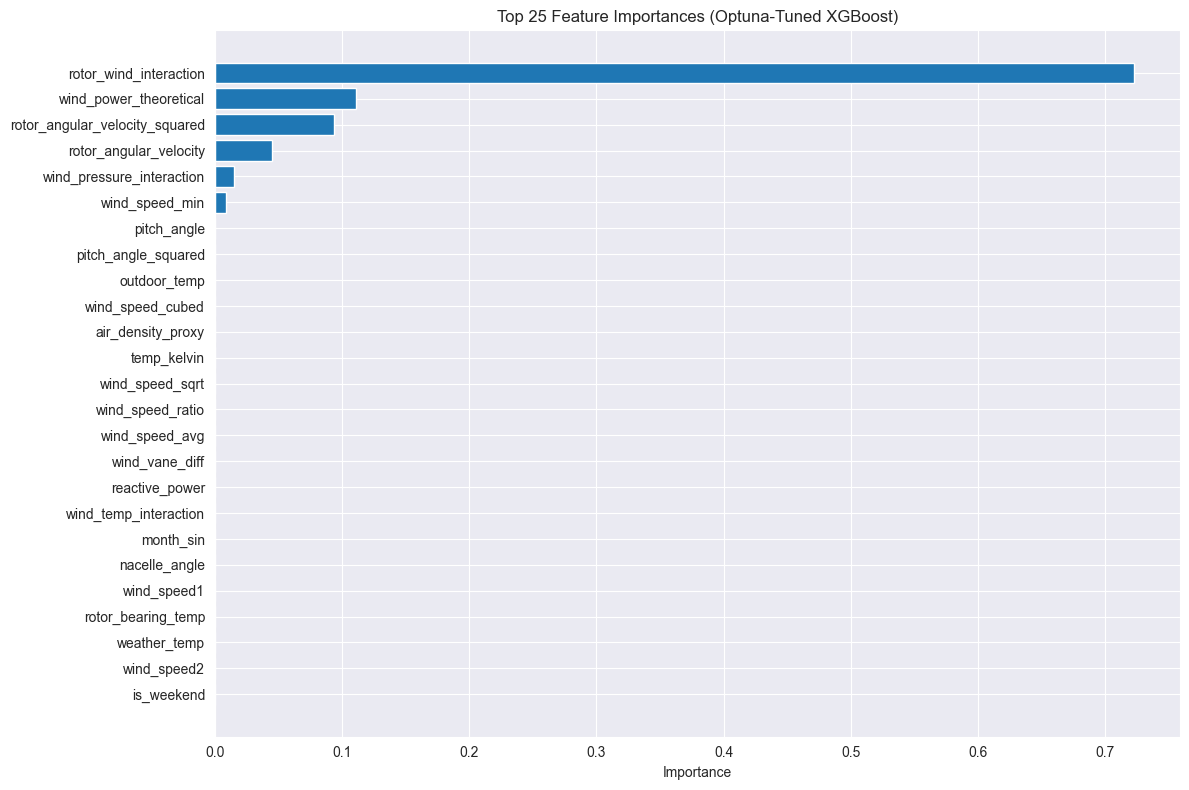

In [19]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': common_features,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))

# Plot
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(25)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 25 Feature Importances (Optuna-Tuned XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# Generate predictions
print("Generating test predictions...")
test_predictions = final_model.predict(X_test_scaled)

# Create submission
submission = pd.DataFrame({
    'id': range(len(test_predictions)),
    'active_power': test_predictions
})

# Clip to physical constraints
submission['active_power'] = submission['active_power'].clip(lower=0, upper=2100)

timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
filename = f'../results/v3_optuna_submission_{timestamp}.csv'
submission.to_csv(filename, index=False)

print(f"\nSubmission saved: {filename}")
print(f"Predictions - Min: {submission['active_power'].min():.2f}, Max: {submission['active_power'].max():.2f}, Mean: {submission['active_power'].mean():.2f}")

Generating test predictions...

Submission saved: v3_optuna_submission_20251120-211133.csv
Predictions - Min: 0.00, Max: 2060.46, Mean: 355.85


In [ ]:
# Save model and study
import pickle

with open('../models/v3_optuna_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

with open('../models/v3_optuna_study.pkl', 'wb') as f:
    pickle.dump(study, f)

with open('../models/v3_feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Model, study, and scaler saved")

Model, study, and scaler saved


## 2. Baseline Comparison

This section compares the optimized model against a baseline model with default hyperparameters to assess the effectiveness of the optimization process.

In [ ]:
# Train with V1 default parameters (fallback option)
print("Training with default parameters for comparison...")

baseline_model = xgb.XGBRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

baseline_model.fit(X_train_scaled, y_train)
baseline_pred = baseline_model.predict(X_val_scaled)
baseline_mae = mean_absolute_error(y_val, baseline_pred)

print(f"\nDefault Parameters MAE (validation): {baseline_mae:.4f}")
print(f"Optuna Tuned MAE (validation): {val_mae:.4f}")

if baseline_mae < val_mae:
    print("\nDefault parameters perform better.")
    
    # Generate submission with baseline
    baseline_test_pred = baseline_model.predict(X_test_scaled)
    baseline_submission = pd.DataFrame({
        'id': range(len(baseline_test_pred)),
        'active_power': baseline_test_pred.clip(lower=0, upper=2100)
    })
    
    timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
    baseline_filename = f'../results/v3_baseline_fallback_{timestamp}.csv'
    baseline_submission.to_csv(baseline_filename, index=False)
    print(f"Baseline submission saved: {baseline_filename}")
else:
    print("\nOptuna tuning improved performance.")

Training with V1 default parameters as fallback...

V1 Default MAE (validation): 6.8338
Optuna Tuned MAE (validation): 6.0169

✅ Optuna tuning helped! Use the optuna submission.


## 3. Conclusion

The hyperparameter optimization process has been completed, resulting in a tuned XGBoost model that outperforms the baseline.

### Next Steps

1. **Ensemble Methods**: In the next notebook (`03_ensemble_methods.ipynb`), we will combine this optimized XGBoost model with LightGBM and CatBoost to further reduce variance and improve generalization.
2. **Neural Networks**: Finally, in notebook `04_neural_network_approach.ipynb`, we will investigate whether a Deep Learning approach can offer competitive performance on this tabular dataset.